Bayan Nezamabad 20251971<br>
Jacob Beck 21304149<br>
Ella Hirche 24267201

Code executes to the end without errors

### References:
[The dataset](https://www.kaggle.com/datasets/shahidulugvcse/national-flowers) <br>
[Going Deeper with Convolutions](https://arxiv.org/pdf/1409.4842) <br>
[Implementation of GoogLeNet on Keras](https://lekhuyen.medium.com/implementation-of-googlenet-on-keras-d9873aeed83c) <br>
[TensorFlow Tutorials](https://www.tensorflow.org/tutorials) <br>
[TensorFlow Docs](https://www.tensorflow.org/api_docs) <br>
[Matplotlib Docs](https://matplotlib.org/stable/)

In [12]:
# Imports
import kagglehub
import os

import numpy as np

from keras import utils, Model
from keras.api.layers import Dense, Dropout, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Concatenate, Input, Flatten
from keras.api.initializers import GlorotUniform, HeNormal
from keras.api.optimizers import SGD, RMSprop, Adam, Lion
from keras.api.callbacks import EarlyStopping

import keras_tuner as kt

import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib import image as mpimg

In [13]:
# Downloading dataset from Kaggle
path = kagglehub.dataset_download("shahidulugvcse/national-flowers")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\bayan\.cache\kagglehub\datasets\shahidulugvcse\national-flowers\versions\1


## The data set
Our dataset consists of images of 9 different types of national flowers which we will be classifying. Various features can be extracted from patterns in our data such as petals, pistils, stems, etc. <br>
The dataset contains images where the flowers are of various sizes, not always centered, part of the flower may be cropped out, images may have borders, images may contain multiple of the flower. <br>
The dataset has two directories, consisting of 4481 files, split roughly 80% in the training directory and 20% in the testing directory. <br>
The images are of varying sizes, so we will have to do some preprocessing to make them of uniform size. <br>

### Data preprocessing
Upon loading the dataset, some preprocessing is performed to make all images 224x224 since that is the requisite input size for GoogLeNet. <br>
The images are also <b>padded</b> to retain the same aspect ratio. Since the features are not always around the center of the image, we chose padding over cropping since we don't want to accidentally crop out valuable features which may have an adverse effect on training.

In [14]:
# Loading the data set
# The train directory contains directories for each class/flower
train_dir = path + '\\flowerdataset\\train'
# The test directory contains directories for each class/flower
test_dir = path + '\\flowerdataset\\test'

# GoogLeNet configurations
input_shape = (224, 224)
batch_size = 128
epochs = 30

verbose = True
class_names = os.listdir(train_dir) # Getting class names based on directory names as each class' data is in a separate directory
NB_CLASSES = len(class_names)

# Loading our training dataset
train_ds = utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode='categorical',
    image_size=input_shape, # Images are resized to the correct dimensions
    pad_to_aspect_ratio=True, # Padding images so as not to lose valuable features & preserve aspect ratio
    validation_split=0.2, # Reserve 20% of our dataset for validation
    subset='training', # Take the 80% of training data
    seed=123, # Use a seed for reproducibility
    verbose=verbose)

# Loading the remainder of our training dataset as our validation dataset
valid_ds = utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode='categorical',
    image_size=input_shape, # Images are resized to the correct dimensions
    pad_to_aspect_ratio=True, # Padding images so as not to lose valuable features & preserve aspect ratio
    validation_split=0.2, # Reserve 20% of our dataset for validation
    subset='validation', # Take the 20% of validation data
    seed=123, # Use a seed for reproducibility
    verbose=verbose)

# Loading our testing dataset
test_ds = utils.image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    image_size=input_shape, # Images are resized to the correct dimensions
    pad_to_aspect_ratio=True, # Padding images so as not to lose valuable features & preserve aspect ratio
    seed=123,
    verbose=verbose)

# Extracting test images and labels from the dataset
X_test = [] # Array of images
y_test = [] # Array of labels corresponding to the images
for x_t, y_t in test_ds:
    for i in range(x_t.shape[0]):
        X_test.append(x_t[i].numpy())
        y_test.append(y_t[i].numpy())

X_test = np.array(X_test)
y_test = np.array(y_test)

Found 3600 files belonging to 9 classes.
Using 2880 files for training.
Found 3600 files belonging to 9 classes.
Using 720 files for validation.
Found 881 files belonging to 9 classes.


An example of padding vs cropping on a sample image is shown below to illustrate how cropping can drastically alter the quality of our training dataset by removing a lot of relevant features. <br>
The left image is unaltered, the center image is padded maintaining aspect ratio, and the right image is cropped maintaining aspect ratio. <br>
As can be seen, the cropped image gets rid of almost the entire flower while the padded image retains all the features of the flower. <br><br>
It should be noted however, that padding does generate black borders around images that need padding which the CNN will have to learn to ignore as it shouldn't contribute to classification.

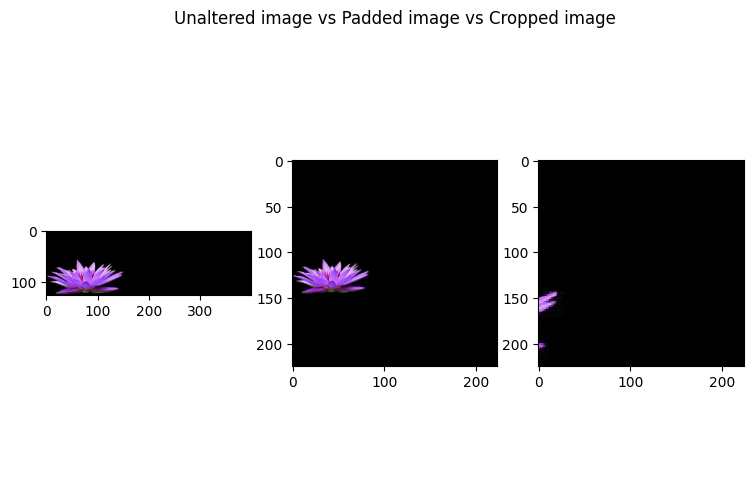

In [4]:
# Padding vs cropping
plt.figure(figsize=(9, 6))
plt.title('Unaltered image vs Padded image vs Cropped image')
plt.axis('off')
image_path = train_dir + '\\Lilly\\334c1f79fd.jpg'

# Displaying unaltered image
ax = plt.subplot(1, 3, 1)
img = mpimg.imread(image_path) / 255.0
plt.imshow(img)

# Displaying padded image
ax = plt.subplot(1, 3, 2)
img = tf.convert_to_tensor(img, dtype=tf.float32)  # resize_with_pad takes a tensor so we convert the image into one here
img = tf.image.resize_with_pad(img, 224, 224)  # generates black (0) padding where needed
plt.imshow(img.numpy())

# Displaying cropped image
ax = plt.subplot(1, 3, 3)
img = utils.load_img(image_path, target_size=input_shape, keep_aspect_ratio=True)  # keep_aspect_ratio crops from the center
plt.imshow(img)

plt.show()


The next preprocessing step is <b>normalisation</b>. We will use min-max normalisation to make all pixel values from the range 0 - 255 to 0 - 1.

In [5]:
# Min-max normalisation
# x represents image data so we divide it by 255 to normalise each image's pixel values
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
valid_ds = valid_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

### Data visualisation

Here we will visualise some of the data.<br>
First we will display a <b>sample image of each class</b> from the testing dataset.
The images contain varying backgrounds and are of varying dimensions. But in our datasets we have scaled them all down to 224x224 for use with our models.<br><br>
Next we will display the <b>class distribution</b> for the training dataset and the testing dataset. As can be seen, the training dataset is entirely evenly distributed, with each class having 400 training images. 80 images of each class are being reserved for validation in accordance with our 80/20 training/validation split. <br>
The testing dataset is also evenly distributed for the most part. The only minor difference is that there are 92 test images for the Daisy class and 89 for the Orchid class. Every other class has 100 test images each.



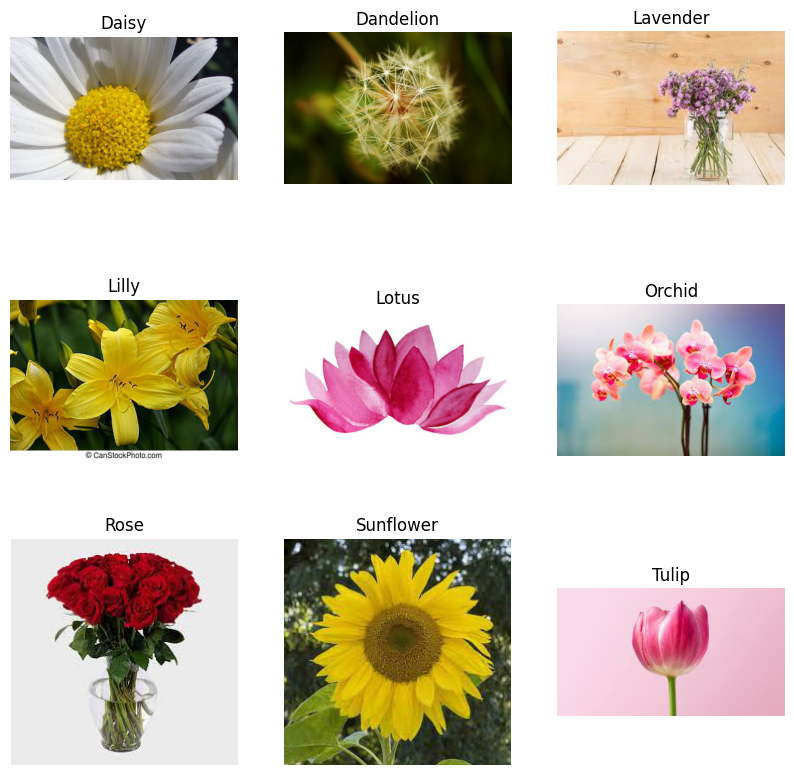

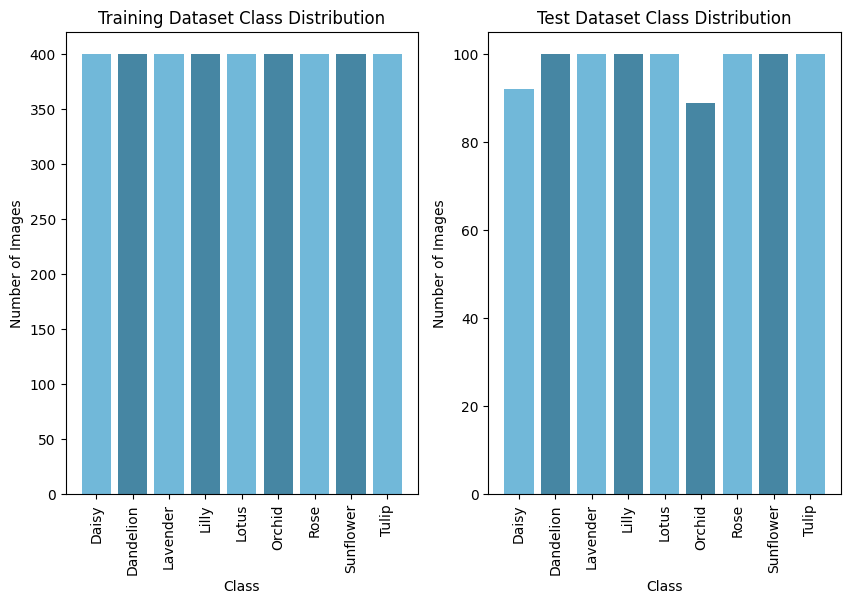

In [6]:
# Data visualisation

# Displaying sample images from the training dataset on a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
# For each class name
for i, class_name in enumerate(class_names):
    image_file = os.listdir(train_dir + '\\' + class_name)[0] # This will get the first image filename in each class
    image_path = train_dir + '\\' + class_name + '\\' + image_file # Constructing the full path to the image
    img = mpimg.imread(image_path)
    axes[i].imshow(img) # Show each image
    axes[i].set_title(class_name) # Display the type of flower it is
    axes[i].set_axis_off()

# Visualising class distribution for the training dataset and the testing dataset
plt.figure(figsize=(10, 6))

# This array stores the number of images per class
class_distribution = []
for name in class_names:
    class_dir = os.path.join(train_dir, name)
    class_distribution.append(len(os.listdir(class_dir)))  # This gives us the length of the array of files in class_dir

ax = plt.subplot(1, 2, 1)
# Displays a bar chart of the class distribution with alternating colours
ax.bar(class_names, class_distribution, color=['#71b8d9', '#4686a3'])
ax.set_title('Training Dataset Class Distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
# Rotating x ticks for readability
ax.tick_params(axis='x', labelrotation=90)

# Now with the testing dataset
class_distribution = []
for name in class_names:
    class_dir = os.path.join(test_dir, name)
    class_distribution.append(len(os.listdir(class_dir)))

ax = plt.subplot(1, 2, 2)
ax.bar(class_names, class_distribution, color=['#71b8d9', '#4686a3'])
ax.set_title('Test Dataset Class Distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.tick_params(axis='x', labelrotation=90)

### Data correlation and feature engineering


## The network structure and hyperparameters

### GoogLeNet
Below are diagrams representing the architecture of GoogLeNet <br>
![googlenet-architecture](https://drive.google.com/uc?id=18wTuj7KmolreoeUlWt9qp6xH5IRIdhxY) <br>
<i>GoogLeNet architecture</i> <br>
![inception-module](https://drive.google.com/uc?id=1RDRB1u-p2nup2MeYcCS9TkyXSbC_t6Qr) <br>
<i>Inception module</i> <br>
![auxiliary-classifier](https://drive.google.com/uc?id=145__39f0Z28chCQF0dGZ6IfeQKQt3Nvj) <br>
<i>Auxiliary classifier</i> <br>

In [7]:
# GoogleNet architecture

# This function is used to determine which optimiser and learning rate pair we will use for the model
# This is used since we want to find the best combination
def make_optimiser(optimiser, learning_rate):
    match(optimiser):
        case 'sgd':
            return SGD(learning_rate=learning_rate)
        case 'rmsprop':
            return RMSprop(learning_rate=learning_rate)
        case 'adam':
            return Adam(learning_rate=learning_rate)
        case 'lion':
            return Lion(learning_rate=learning_rate)

# Inception module paths with layers
def build_inception_module(input_layer, filters):
    path1 = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(input_layer)

    path2 = Conv2D(filters=filters[1][0], kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(input_layer)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=HeNormal())(path2)

    path3 = Conv2D(filters=filters[2][0], kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(input_layer)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5, 5), padding='same', activation='relu', kernel_initializer=HeNormal())(path3)

    path4 = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same')(input_layer)
    path4 = Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(path4)

    inception_layer = Concatenate(axis=-1)([path1, path2, path3, path4])
    return inception_layer


def build_auxiliary_classifier(input_layer, name):
    aux = AvgPool2D(pool_size=(5, 5), strides=3, padding='valid')(input_layer)
    aux = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(aux)
    aux = Flatten()(aux)
    aux = Dense(units=1024, activation='relu', kernel_initializer=HeNormal())(aux)
    aux = Dropout(rate=0.5)(aux) # Changed from 0.7
    aux = Dense(units=NB_CLASSES, activation='softmax', kernel_initializer=GlorotUniform(), name=name)(aux)

    return aux

# Build layers in the GoogLeNet architecture
def build_googlenet_model(tuner = None):
    # Input images are 224x224 with 3 channels for RGB
    input_layer = Input(shape=(224, 224, 3))

    layer = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same', activation='relu', kernel_initializer=HeNormal())(input_layer)
    layer = BatchNormalization()(layer)
    layer = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    layer = Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu', kernel_initializer=HeNormal())(layer)
    layer = Conv2D(filters=192, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer=HeNormal())(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    layer = build_inception_module(layer, [64, (96, 128), [16, 32], 32])
    layer = build_inception_module(layer, [128, (128, 192), [32, 96], 64])

    layer = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    layer = build_inception_module(layer, [192, (96, 208), [16, 48], 64])
    auxiliary1 = build_auxiliary_classifier(layer, 'aux1')
    layer = build_inception_module(layer, [160, (112, 224), [24, 64], 64])
    layer = build_inception_module(layer, [128, (128, 256), [24, 64], 64])
    layer = build_inception_module(layer, [112, (144, 288), [32, 64], 64])
    auxiliary2 = build_auxiliary_classifier(layer, 'aux2')
    layer = build_inception_module(layer, [256, (160, 320), [32, 128], 128])

    layer = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    layer = build_inception_module(layer, [256, (160, 320), (32, 128), 128])
    layer = build_inception_module(layer, [384, (192, 384), (48, 128), 128])

    layer = AvgPool2D(pool_size=(7, 7), strides=1, padding='valid')(layer)
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    output_layer = Dense(units=NB_CLASSES, activation='softmax', kernel_initializer=GlorotUniform(), name='output')(layer)

    model = Model(inputs=input_layer, outputs=[output_layer, auxiliary1, auxiliary2], name='GoogLeNet')
    
    if tuner is not None:
        learning_rate = tuner.Choice('learning_rate', [0.001, 0.0001, 0.00005, 0.00001])
        optimiser_choice = tuner.Choice('optimiser', ['sgd', 'rmsprop', 'adam', 'lion'])
    
        optimiser = make_optimiser(optimiser_choice, learning_rate)
    
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])
        
    return model
                                                                        
googlenet = build_googlenet_model()
googlenet.summary()

Model: "GoogLeNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        768 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]  

 Total params: 10,331,979 (39.41 MB)

 Trainable params: 10,331,467 (39.41 MB)

 Non-trainable params: 512 (2.00 KB)

## Loss Function

## Optimiser

In [8]:
# Instantiating our tuner to find the best performing optimiser and learning rate (LR) pair based on validation loss
tuner = kt.Hyperband(build_googlenet_model,
                     objective='val_loss',
                     max_epochs=epochs,
                     directory='googlenet',
                     project_name='GoogLeNet')

tuner.search(train_ds, validation_data=valid_ds, epochs=epochs)

best_pair = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'The best performing pair uses optimiser {best_pair.get('optimiser')} with learning rate {best_pair.get('learning_rate')}')

Trial 14 Complete [00h 01m 40s]
val_loss: 1.8508614301681519

Best val_loss So Far: 1.8508614301681519
Total elapsed time: 00h 22m 35s
The best performing pair uses optimiser lion with learning rate 0.0001


In [9]:
# Training a model with the best performing optimiser & LR pair to find an optimal number of epochs to use
# Build the model with the optimiser & LR
googlenet = build_googlenet_model()
optimiser = make_optimiser(best_pair.get('optimiser'), best_pair.get('learning_rate'))

googlenet.compile(optimizer=optimiser,
                  loss={'output': 'categorical_crossentropy', 'aux1': 'categorical_crossentropy', 'aux2': 'categorical_crossentropy'},
                  loss_weights={'output': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  metrics=['accuracy', 'accuracy', 'accuracy'])

stop_early = EarlyStopping(monitor='val_output_accuracy', patience=5, verbose=1, mode='max')
# Going 20 epochs over the initial estimate of 30 to see if there is much to be gained from additional epochs
history = googlenet.fit(train_ds, validation_data=valid_ds, epochs=epochs+20, batch_size=128, verbose=verbose, callbacks=[stop_early])

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 497ms/step - loss: 1.0398 - output_accuracy: 0.1801 - val_loss: 0.6474 - val_output_accuracy: 0.1569
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 494ms/step - loss: 0.4750 - output_accuracy: 0.4414 - val_loss: 0.5763 - val_output_accuracy: 0.2611
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 495ms/step - loss: 0.3857 - output_accuracy: 0.5408 - val_loss: 0.4798 - val_output_accuracy: 0.4361
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 494ms/step - loss: 0.3327 - output_accuracy: 0.6135 - val_loss: 0.4489 - val_output_accuracy: 0.4875
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 495ms/step - loss: 0.2952 - output_accuracy: 0.6588 - val_loss: 0.3882 - val_output_accuracy: 0.5597
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 495ms/step - loss: 0.2731 - output_accuracy: 0.7030 - val_loss: 0.4567 - val_output_accuracy: 0.5583
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 495ms/step - loss: 0.2431 - output_accuracy: 0.7362 - val_loss: 0.3290 - val_output_accuracy: 0.6472

In [20]:
# Get the validation accuracy for each epoch
val_accuracy_by_epoch = history.history['val_output_accuracy']
# Find the epoch number with the highest validation accuracy (+1 since arrays start at 0)
# Reassign epochs as this is now the number we will use for future training
epochs = val_accuracy_by_epoch.index(max(val_accuracy_by_epoch)) + 1
print(f'The model had the best validation accuracy after {epochs} epochs')

The model had the best validation accuracy after 18 epochs


## Cross-fold validation

In [ ]:
# We will now retrain the model once more with the optimal epoch number
full_train_ds = utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode='categorical',
    image_size=input_shape, # Images are resized to the correct dimensions
    pad_to_aspect_ratio=True, # Padding images so as not to lose valuable features & preserve aspect ratio
    seed=123, # Use a seed for reproducibility
    verbose=verbose)

# Training models with Cross Fold Validation

# Splits is the number of folds
splits = 5
# Total number of elements in the training data
dataset_size = len(list(full_train_ds))
# The number of elements in each fold
fold_size = dataset_size // splits
# The results of each fold will be stored in these arrays
googlenet_scores = []
googlenet_evaluation = []

# For each fold we will split the training data into 3 parts, 2 for training and 1 for validation and repeat for each possible permutation
for fold in range(splits):
    # Create a new model
    googlenet = build_googlenet_model()
    # Re-instantiate the optimiser
    optimiser = make_optimiser(best_pair.get('optimiser'), best_pair.get('learning_rate'))
    googlenet.compile(optimizer=optimiser,
                  loss={'output': 'categorical_crossentropy', 'aux1': 'categorical_crossentropy', 'aux2': 'categorical_crossentropy'},
                  loss_weights={'output': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  metrics=[['accuracy', 'precision', 'recall'], ['accuracy', 'precision', 'recall'], ['accuracy', 'precision', 'recall']])
    # Train the model with the specific training sets and validation set
    # Get the 'fold'th' third of the training data for validation (either the 1st, 2nd, or 3rd third)
    valid_fold = full_train_ds.skip(fold * fold_size).take(fold_size)
    # Get the remaining training data for training (gets the data after the validation split and concatenates the data before the validation split)
    train_fold = full_train_ds.skip((fold+1) * fold_size).concatenate(full_train_ds.take(fold * fold_size))
    
    googlenet_scores.append(googlenet.fit(train_fold, epochs=epochs, validation_data=valid_fold, batch_size=128, verbose=verbose))
    # Evaluate the model and store the results
    googlenet_evaluation.append(googlenet.evaluate(X_test, y_test))

Found 3600 files belonging to 9 classes.
Epoch 1/18
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 1.2086 - output_accuracy: 0.1275 - output_precision: 0.1195 - output_recall: 0.0257